# Install the required libraries

In [ ]:
!pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00


# Import the required libraries

In [ ]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import hvplot.pandas
from collections import Counter
import datetime
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.ensemble import GradientBoostingRegressor

# Connect to google drive and import the csv as dataframe

In [ ]:
drive.mount('/content/drive')
# File path in Google Drive
file_path = '/content/drive/My Drive/train.csv'

# Read the file into a DataFrame
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


# Clean the dataset

In [ ]:
print('sum of duplicated values: ', df.duplicated().sum())
print('sum of Null values: ', df.isnull().sum().sum(), '\n')

df.info()

sum of duplicated values:  0
sum of Null values:  111133 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthd

In [ ]:
# Remove unnecessary columns
df = df.drop(["user/ageInSeconds"], axis=1)
df = df.drop(["user/birthdayRaw"], axis=1)
df = df.drop(["user/birthdayUnix"], axis=1)
df = df.drop(["user/profileName"], axis=1)
df = df.drop(['user/gender'],axis = 1)
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708


In [ ]:
print('sum of Null values: ', df.isnull().sum().sum(), '\n')
df.info()

sum of Null values:  10 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 4.0+ MB


In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 37499
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37490 non-null  int64  
 1   beer/ABV           37490 non-null  float64
 2   beer/beerId        37490 non-null  int64  
 3   beer/brewerId      37490 non-null  int64  
 4   beer/name          37490 non-null  object 
 5   beer/style         37490 non-null  object 
 6   review/appearance  37490 non-null  float64
 7   review/aroma       37490 non-null  float64
 8   review/overall     37490 non-null  float64
 9   review/palate      37490 non-null  float64
 10  review/taste       37490 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37490 non-null  object 
 13  review/timeUnix    37490 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 4.3+ MB


 # Top 5 breweries which produce the strongest beers
 To answer this question, we calculate the mean of beer/ABV by beer/brewerId.Then rank top5 beer brewer by beer/ABV to get the rank.

In [ ]:
def top_n_breweries_by_ABS(n:int):
    breweries_and_ABV = df[['beer/ABV', 'beer/beerId', 'beer/name','beer/brewerId']].groupby('beer/brewerId')['beer/ABV'].mean().sort_values(ascending = False).reset_index()
    breweries_and_ABV['rank'] = breweries_and_ABV['beer/ABV'].rank(method = 'dense', ascending = False)
    result = breweries_and_ABV[breweries_and_ABV['rank'] <= n]
    return result

top_n_breweries_by_ABS(5)

,beer/brewerId,beer/ABV,rank
0,6513,20.454545,1.0
1,2412,9.700000,2.0
2,1199,8.896660,3.0
3,1127,8.750000,4.0
4,14879,8.749085,5.0


#Correlation between various reviews

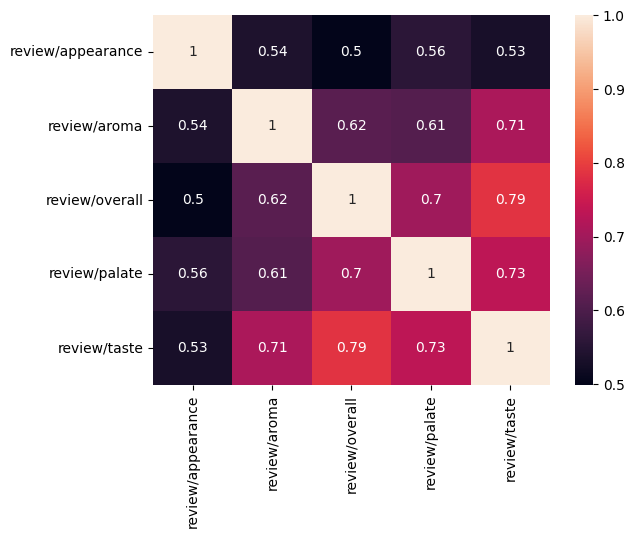

In [ ]:
corr_df = df[['review/appearance', 'review/aroma', 'review/overall', 'review/palate', 'review/taste']]
corr_df.corr(method = 'pearson')
_ = sns.heatmap(data=corr_df.corr(), annot=True)

#How ABV correlates to the Overall Rating

In [ ]:
#abv
df_abv = df[['beer/ABV','review/overall']]
df_abv = pd.DataFrame(df_abv)
x = df_abv['beer/ABV']

x1 = x.min()
x2 = x.max()
yy = df_abv['review/overall']
x = x.tolist()

yy = yy.tolist()
abvRe = linregress(x,yy)
abvr = abvRe
print(abvr)
abvr1 = abvr[0]*x1 + abvr[1]
print(abvr1)
abvr2 = abvr[0]*x2 + abvr[1]
print(abvr2)

LinregressResult(slope=0.059459683206813135, intercept=3.449063769258233, rvalue=0.19678020456617795, pvalue=0.0, stderr=0.0015300987057754024, intercept_stderr=0.011870097939310492)
3.4550097375789144
6.879887490291351


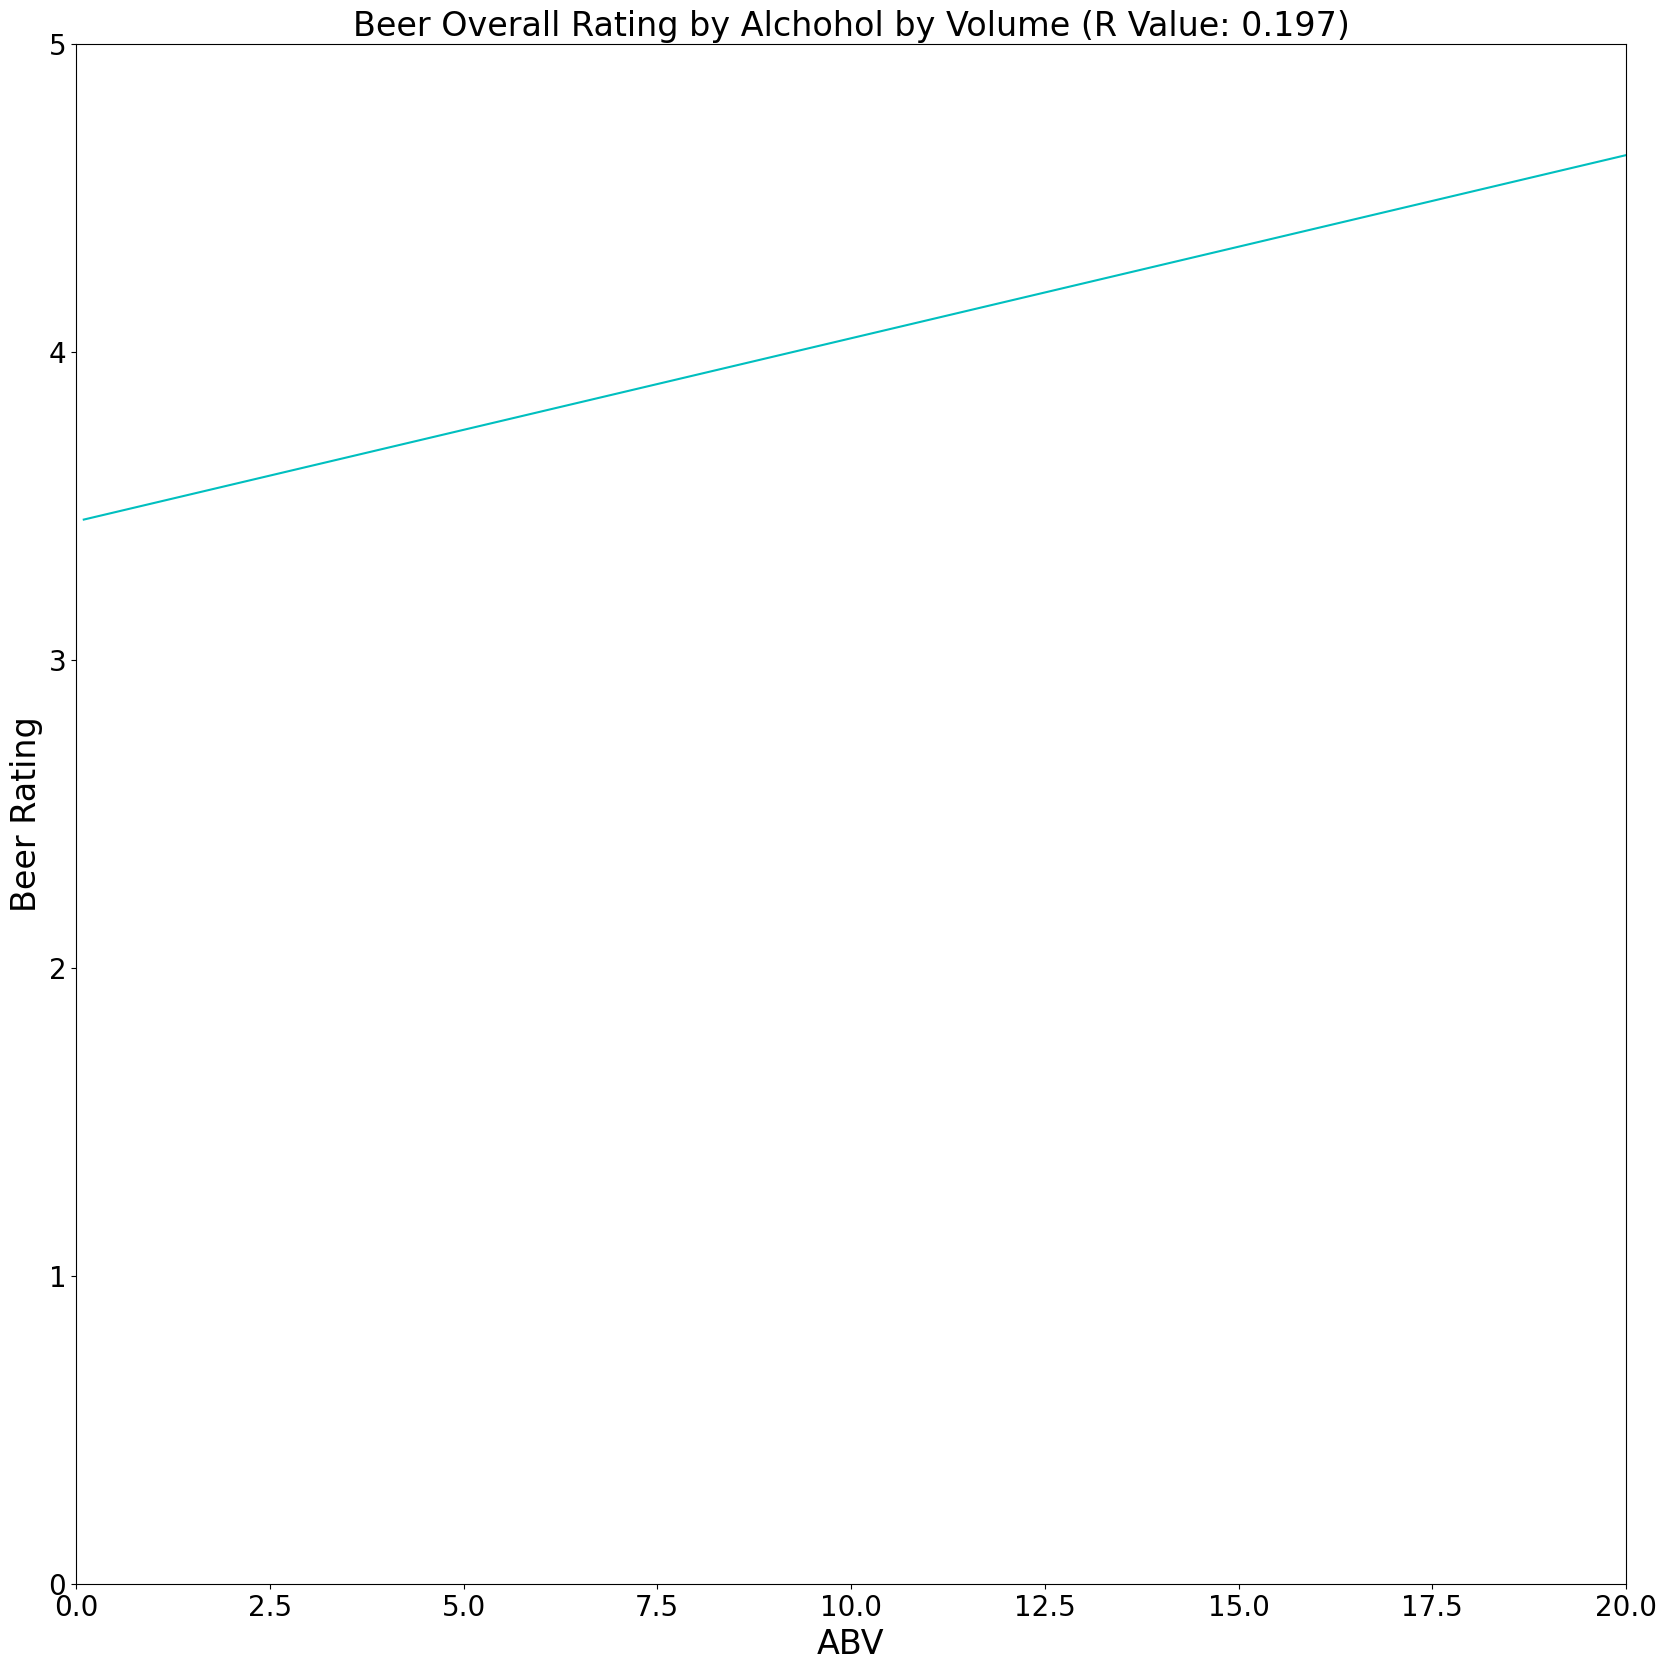

In [ ]:
#plot abv vs overall rating
plt.figure(figsize=(20,20))
r = np.round(abvr[2], 3)
plt.title(f'Beer Overall Rating by Alchohol by Volume (R Value: {r})', fontsize=24)
plt.xlabel('ABV', fontsize=24)
plt.ylabel('Beer Rating', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot([x1,x2] ,[abvr1,abvr2], 'c-')
plt.xlim(0,20)
plt.ylim(0,5)
plt.show()

#Plot the total number of drinks per beer ABV

<ipython-input-17-a5f64e0996dd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["beer/ABV"], bins=50, kde=False, color="m")


Text(0, 0.5, 'Total number of drinks')

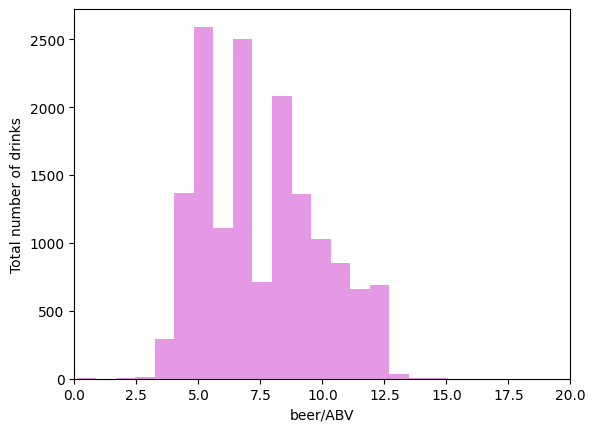

In [ ]:
f, ax = plt.subplots()
sns.distplot(df["beer/ABV"], bins=50, kde=False, color="m")
ax.set_xlim(0, 20)
ax.set_ylabel("Total number of drinks")


# Average Ratings by Beer Style

In [ ]:

# Calculate average rating by beer style
avg_rating_by_style = df.groupby('beer/style')['review/overall'].mean().reset_index()


# Sort by average rating in descending order
avg_rating_by_style = avg_rating_by_style.sort_values(by='review/overall', ascending=False)

# Create bar plot using barplot
bar_plot = avg_rating_by_style.hvplot.bar(x='beer/style', y='review/overall',
                                          title='Average Ratings by Beer Style',
                                          xlabel='Beer Style', ylabel='Average Rating',
                                          height=600,width=900, rot=90,
                                          color='#E58606',
                                          tools=['hover'])


In [ ]:
# Show the plot
bar_plot

:Bars   [beer/style]   (review/overall)

In [ ]:
hvplot.save(bar_plot, 'test.html')

#Feature engineering

In [ ]:
df["review/length"] = df["review/text"].apply(lambda x: len(x))
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,review/length
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,519
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,568
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,392
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,391
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,486


In [ ]:
df["beer/name_length"] = df["beer/name"].apply(lambda x: len(x))
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,review/length,beer/name_length
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,519,8
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,568,24
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,392,20
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,391,15
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,486,25


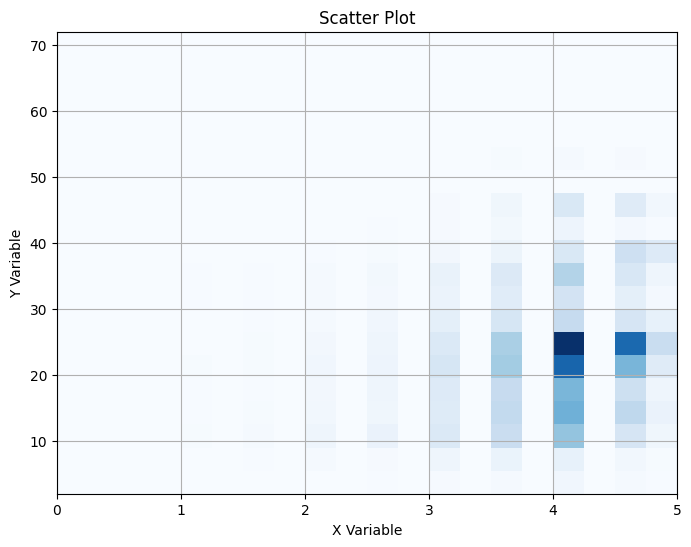

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.hist2d(df['review/overall'], df['beer/name_length'], bins=20,cmap='Blues')
#plt.plot(df['review/overall'], df['beer/name_length'],color='blue', marker='o')  # 'o' for circle marker
plt.title('Scatter Plot')
plt.xlabel('X Variable')
plt.ylabel('Y Variable')
plt.grid(True)  # Add grid lines
plt.show()

#Handle categorical features

In [ ]:
df['beer/style'].value_counts()

American Double / Imperial Stout    4493
American IPA                        3048
American Double / Imperial IPA      2871
Scotch Ale / Wee Heavy              2133
Russian Imperial Stout              2030
                                    ... 
Kristalweizen                          6
Berliner Weissbier                     6
Eisbock                                5
BiÃ¨re de Garde                        4
Flanders Red Ale                       2
Name: beer/style, Length: 95, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical feature
df['beer_style_encoded'] = label_encoder.fit_transform(df['beer/style'])

# Print the mapping of original categories to encoded numeric values
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category mapping:", category_mapping)

Category mapping: {'Altbier': 0, 'American Adjunct Lager': 1, 'American Amber / Red Ale': 2, 'American Amber / Red Lager': 3, 'American Barleywine': 4, 'American Black Ale': 5, 'American Blonde Ale': 6, 'American Brown Ale': 7, 'American Dark Wheat Ale': 8, 'American Double / Imperial IPA': 9, 'American Double / Imperial Pilsner': 10, 'American Double / Imperial Stout': 11, 'American IPA': 12, 'American Malt Liquor': 13, 'American Pale Ale (APA)': 14, 'American Pale Lager': 15, 'American Pale Wheat Ale': 16, 'American Porter': 17, 'American Stout': 18, 'American Strong Ale': 19, 'American Wild Ale': 20, 'Baltic Porter': 21, 'Belgian Dark Ale': 22, 'Belgian IPA': 23, 'Belgian Pale Ale': 24, 'Belgian Strong Dark Ale': 25, 'Belgian Strong Pale Ale': 26, 'Berliner Weissbier': 27, 'BiÃ¨re de Garde': 28, 'Black & Tan': 29, 'Bock': 30, 'Braggot': 31, 'California Common / Steam Beer': 32, 'Chile Beer': 33, 'Cream Ale': 34, 'Czech Pilsener': 35, 'Doppelbock': 36, 'Dortmunder / Export Lager': 37

#Plot the frequency distribution of the overall review

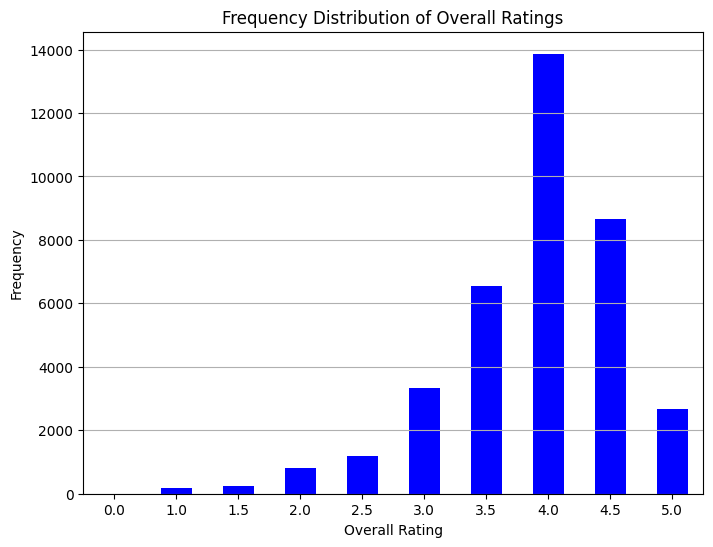

In [ ]:
# Calculate frequency distribution
frequency_distribution = df['review/overall'].value_counts().sort_index()

# Plot frequency distribution
plt.figure(figsize=(8, 6))
frequency_distribution.plot(kind='bar', color='blue')
plt.title('Frequency Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y')  # Add grid lines on y-axis
plt.show()

#Sentiment Analysis of review text

In [ ]:

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]  # Remove stopwords and lemmatization
    return " ".join(filtered_tokens)

df['clean_text'] = df['review/text'].apply(preprocess_text)

# Sentiment analysis using TextBlob
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Using polarity as sentiment score

df['sentiment_score'] = df['clean_text'].apply(calculate_sentiment)

# Calculate correlation between sentiment scores and overall rating
correlation = df['sentiment_score'].corr(df['review/overall'])

print(f"Correlation between sentiment scores and overall rating: {correlation}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Correlation between sentiment scores and overall rating: 0.31752617741678263


In [ ]:
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,clean_text,sentiment_score
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,pours clouded gold thin white head nose quite ...,-0.054924
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,12oz bottle 8oz snifter deep ruby red hue one ...,0.043640
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,first enjoyed brewpub 2 year ago finally manag...,0.201515
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,first thing noticed pouring green bottle glass...,0.272917
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,pours amber one finger head strong pour head r...,0.269481


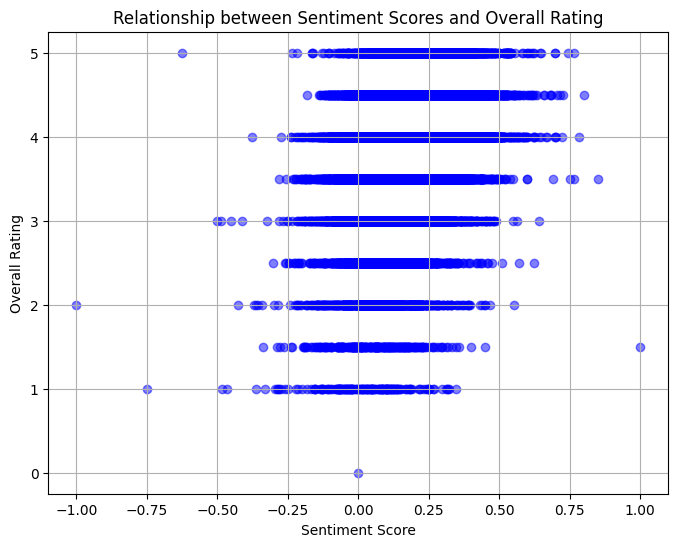

In [ ]:
# Plotting the relationship between sentiment scores and overall rating
plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment_score'], df['review/overall'], color='blue', alpha=0.5)
plt.title('Relationship between Sentiment Scores and Overall Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Overall Rating')
plt.grid(True)
plt.show()

#Find out the most common words in reviwes with higher ratings and lower ratings

In [ ]:
# Filter the DataFrame based on rating criteria
high_rating_df = df[df['review/overall'] >= 4.7]
low_rating_df = df[df['review/overall'] <= 1.5]

# Tokenize the review texts
high_rating_tokens = [word for text in high_rating_df['clean_text'] for word in word_tokenize(text.lower())]
low_rating_tokens = [word for text in low_rating_df['clean_text'] for word in word_tokenize(text.lower())]

# Count the occurrences of each word
high_rating_word_counts = Counter(high_rating_tokens)
low_rating_word_counts = Counter(low_rating_tokens)

# Get the most common words
top_high_rating_words = high_rating_word_counts.most_common(15)
top_low_rating_words = low_rating_word_counts.most_common(15)

print("Top words in reviews with ratings > 4.7:")
print(top_high_rating_words)

print("\nTop words in reviews with ratings < 1.5:")
print(top_low_rating_words)

Top words in reviews with ratings > 4.5:
[('beer', 5270), ('head', 2624), ('coffee', 2457), ('chocolate', 2385), ('taste', 2256), ('flavor', 2151), ('one', 2033), ('hop', 1986), ('malt', 1961), ('dark', 1886), ('like', 1757), ('nice', 1648), ('smell', 1521), ('bourbon', 1348), ('good', 1332)]

Top words in reviews with ratings < 1.0:
[('beer', 820), ('taste', 466), ('like', 435), ('head', 352), ('smell', 295), ('one', 253), ('malt', 238), ('flavor', 223), ('bottle', 220), ('hop', 203), ('light', 196), ('good', 196), ('sweet', 192), ('carbonation', 175), ('would', 160)]


#Best beers to recommend

In [ ]:
df['beer/style'].value_counts()

American Double / Imperial Stout    4493
American IPA                        3048
American Double / Imperial IPA      2871
Scotch Ale / Wee Heavy              2133
Russian Imperial Stout              2030
                                    ... 
Kristalweizen                          6
Berliner Weissbier                     6
Eisbock                                5
BiÃ¨re de Garde                        4
Flanders Red Ale                       2
Name: beer/style, Length: 95, dtype: int64

#Creating models

In [ ]:
y = df['review/overall'].values

In [ ]:
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,review/length,beer/name_length,beer_style_encoded,clean_text,sentiment_score
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,519,8,61,pours clouded gold thin white head nose quite ...,-0.054924
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,568,24,4,12oz bottle 8oz snifter deep ruby red hue one ...,0.043640
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,392,20,14,first enjoyed brewpub 2 year ago finally manag...,0.201515
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,391,15,35,first thing noticed pouring green bottle glass...,0.272917
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,486,25,46,pours amber one finger head strong pour head r...,0.269481


In [ ]:
X = df.drop(columns = ['index','beer/beerId','beer/brewerId','beer/name','beer/style','review/text','review/timeStruct','review/timeUnix','clean_text']) # independent variables

In [ ]:
X.head()

,beer/ABV,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/length,beer/name_length,beer_style_encoded,sentiment_score
0,5.0,4.0,4.0,4.0,4.0,4.0,519,8,61,-0.054924
1,11.0,4.0,3.5,3.5,3.5,3.0,568,24,4,0.043640
2,4.7,3.5,4.0,3.5,3.5,3.5,392,20,14,0.201515
3,4.4,3.0,3.0,2.5,3.0,3.0,391,15,35,0.272917
4,4.4,4.0,3.0,3.0,3.5,2.5,486,25,46,0.269481


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

#GridSearchCV (Hyperparmater Tuning)

In [ ]:
from sklearn.model_selection import GridSearchCV
## Hyperparmater Tuning
def hyperparameter_model(grid, model):
    cv = GridSearchCV(estimator = model, param_grid = grid,cv = 3, n_jobs = -1,verbose = 2)
    cv.fit(X_train, y_train)
    print(cv.best_params_)
    return cv

#Linear Regression

In [ ]:
params = {
    'num_leaves': [7, 14, 21, 28, 35, 42],
    'learning_rate': [0.4, 0.04, 0.004,0.01,0.1],
    'max_depth': [-1, 2, 4, 5,7],
    'n_estimators': [50, 150, 250, 400,700],
}
grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, scoring='r2', cv=5,verbose = 2)
grid.fit(X_train, y_train)

reg = lgb.LGBMRegressor(random_state=0)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 20994, number of used features: 10
[LightGBM] [Info] Start training from score 3.890850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

KeyboardInterrupt: 

In [ ]:

parameters = {'learning_rate': [0.01,0.02,0.03,0.04,0.05],
                  'subsample'    : [0.9, 0.7, 0.5, 0.3, 0.1],
                  'n_estimators' : [250,500,750, 1000,1250],
                  'max_depth'    : [2,4,6,8,10]
            }
GBR = GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1,verbose = 2)
grid_GBR.fit(X_train, y_train)
reg.score(X_test,y_test)

Fitting 2 folds for each of 625 candidates, totalling 1250 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVR
param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},

modelsvr = SVR(),

grids = GridSearchCV(modelsvr,param,cv=5)

#grids.fit(X_train,y_train)